In [267]:
"""
HERFD Simulation
by Yanna Chen, yannachen@anl.gov

Version note: 
From HERFD v1, beam focus from SBCA is added. 
v1.1 has multiple reflected lines to indicate  the Johann error.
v1.1.1 set np.radians(beta_deg) = 2*alpha 
v1.1.1s for symmetric design
v1.1 for symmetric design
v2 Add 3D and merge symmetric and asymmetric, add auto find hkl
"""

'\nHERFD Simulation\nby Yanna Chen, yannachen@anl.gov\n\nVersion note: \nFrom HERFD v1, beam focus from SBCA is added. \nv1.1 has multiple reflected lines to indicate  the Johann error.\nv1.1.1 set np.radians(beta_deg) = 2*alpha \nv1.1.1s for symmetric design\nv1.1 for symmetric design\nv2 Add 3D and merge symmetric and asymmetric\n'

In [268]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

# Constants
(Please use units: mm, nm, eV)

## Physical constant

In [269]:
# Plank constant times the light speed
hc = 1239.84193  # The following energy should be in the unit of eV

## Setup constant 

In [270]:
# define sample position in Cartesian coordinate 
sample_x = 0
sample_y = 457.2 # mm = 18 inch
sample_z = 0

# Roland Circle diameter
D = 500 # unit: mm
# Crystal diameter
crysD = 100 # unit: mm
# Angles between each SBCA and X-ray beam
angles2beam = np.arange(60,121,20)

# Si lattice constant
lattice_cons = 0.5431  # unit: nm
hkl0 = [2,1,1] # lattice plane for SBCA
hkl_phi0 = [1,1,1] # set [1,1,1] as phi=0
theta_bragg_range = np.arange(60,85,1)

# Crystal stage
vert0 = 0

In [271]:
hkl_list = [[9,7,7],
            [9,9,3],
            [10,8,2],
            [9,9,1],
            [9,7,5],
            [10,6,4],
            [7,7,7],
            [8,8,4],
            [9,7,3],
            [10,6,0],
            [9,7,1],
            [8,8,0],
            [7,7,5],
            [10,4,2],
            [9,5,3],
            [9,5,1],
            [10,2,0],
            [9,3,3],
            [8,4,4],
            [9,3,1],
            [6,6,4],
            [9,1,1],
            [8,4,0],
            [7,5,1],
            [8,2,2],
            [7,3,3],
            [7,3,1],
            [6,4,2],
            [7,1,1],
            [4,4,4],
            ]

In [303]:
# To calculate energy, e.g. [7,3,1] and [7,1,3] are the same, only [7,3,1] is created.
def generate_hkl(n):
    hkl_list = []
    for h in range(n+1):
        for k in range(h+1):
                for l in range(h+1):
                    # Check if h, k, l are all odd
                    if (h % 2 != 0 and k % 2 != 0 and l % 2 != 0):
                        hkl = sorted([h, k, l], reverse=True)
                        if hkl not in hkl_list:
                            hkl_list.append(hkl)
                    # Check if h, k, l are all even and their sum is a multiple of 4
                    elif (h % 2 == 0 and k % 2 == 0 and l % 2 == 0):
                        if (h + k + l) % 4 == 0 and (h, k, l) != (0, 0, 0):
                            hkl = sorted([h, k, l], reverse=True)
                            if hkl not in hkl_list:
                                hkl_list.append(hkl)
    return hkl_list
# To create phi-alpha 2D plot, e.g. [7,3,1] and [7,1,3] are both used.
def generate_hkl_phi(n):
    hkl_list = []
    for h in range(n+1):
        for k in range(n+1):
                for l in range(n+1):
                    if (h % 2 != 0 and k % 2 != 0 and l % 2 != 0):
                        hkl = [h, k, l]
                        if hkl not in hkl_list:
                            hkl_list.append(hkl)
                    elif (h % 2 == 0 and k % 2 == 0 and l % 2 == 0):
                        if (h + k + l) % 4 == 0 and (h, k, l) != (0, 0, 0):
                            hkl = [h, k, l]
                            if hkl not in hkl_list:
                                hkl_list.append(hkl)
    return hkl_list

def order_hkl_by_sum_of_squares(hkl_list):
    return sorted(hkl_list, key=lambda x: 1/(x[0]**2 + x[1]**2 + x[2]**2))

ordered_hkl_list = order_hkl_by_sum_of_squares(generate_hkl(16))
ordered_hkl_list_phi = order_hkl_by_sum_of_squares(generate_hkl_phi(10))

print(ordered_hkl_list_phi)


[[8, 10, 10], [10, 8, 10], [10, 10, 8], [9, 9, 9], [4, 10, 10], [10, 4, 10], [10, 10, 4], [7, 9, 9], [9, 7, 9], [9, 9, 7], [0, 10, 10], [6, 8, 10], [6, 10, 8], [8, 6, 10], [8, 10, 6], [10, 0, 10], [10, 6, 8], [10, 8, 6], [10, 10, 0], [8, 8, 8], [5, 9, 9], [9, 5, 9], [9, 9, 5], [7, 7, 9], [7, 9, 7], [9, 7, 7], [3, 9, 9], [9, 3, 9], [9, 9, 3], [2, 8, 10], [2, 10, 8], [8, 2, 10], [8, 10, 2], [10, 2, 8], [10, 8, 2], [1, 9, 9], [9, 1, 9], [9, 9, 1], [5, 7, 9], [5, 9, 7], [7, 5, 9], [7, 9, 5], [9, 5, 7], [9, 7, 5], [4, 6, 10], [4, 10, 6], [6, 4, 10], [6, 10, 4], [10, 4, 6], [10, 6, 4], [7, 7, 7], [4, 8, 8], [8, 4, 8], [8, 8, 4], [3, 7, 9], [3, 9, 7], [7, 3, 9], [7, 9, 3], [9, 3, 7], [9, 7, 3], [0, 6, 10], [0, 10, 6], [6, 0, 10], [6, 6, 8], [6, 8, 6], [6, 10, 0], [8, 6, 6], [10, 0, 6], [10, 6, 0], [1, 7, 9], [1, 9, 7], [5, 5, 9], [5, 9, 5], [7, 1, 9], [7, 9, 1], [9, 1, 7], [9, 5, 5], [9, 7, 1], [0, 8, 8], [8, 0, 8], [8, 8, 0], [5, 7, 7], [7, 5, 7], [7, 7, 5], [2, 4, 10], [2, 10, 4], [4, 2, 10

## Note:

In [273]:
# Crystal arc angle
np.degrees(np.arcsin(crysD/2/D))*2

11.478340954533573

# Functions

## Calculate Bragg angle

In [274]:
def theta_bragg(energy_val, hkl=[4,4,4]):
    """
    theta_bragg unit: deg
    """
    d_spacing = lattice_cons / np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)
    theta_bragg_val = np.arcsin(hc / (energy_val * 2 * d_spacing))
    theta_bragg_val = np.degrees(theta_bragg_val)
    return theta_bragg_val

## Calculate energy 

In [275]:
def energy(theta_bragg, hkl=[4,4,4]):
    """
    theta_bragg unit: deg
    """
    d_spacing = lattice_cons / np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)
    energy = hc / (2 * d_spacing * np.sin(np.radians(theta_bragg)))
    return energy

## Calculate asymmetry angle

In [276]:
    
def cal_alpha(hkl1=[2,1,1], hkl2=[4,4,4]):
    """
    alpha unit: deg
    """
    cos_alpha = (hkl1[0]*hkl2[0]+hkl1[1]*hkl2[1]+hkl1[2]*hkl2[2])/np.sqrt(hkl1[0]**2+hkl1[1]**2+hkl1[2]**2)/np.sqrt(hkl2[0]**2+hkl2[1]**2+hkl2[2]**2)
    if cos_alpha>1:
        cos_alpha=1
    alpha = np.arccos(cos_alpha)
    alpha = np.degrees(alpha)
    return alpha

## Reflected line based on lattice plane normal direction 

In [277]:
def angle_between_lines(slope0, slope1):
    """
    angle unit: deg
    """
    return np.degrees(np.arctan(np.abs((slope1 - slope0) / (1 + slope0 * slope1))))

def reflected_line(slope_angle, x0, y0, x1, y1, x2,figure=True):
    """
    slop angle: for SBCA normal line ; unit deg
    x0,y0: cross point
    x1,y1: incident beam start point
    x2: reflected beam end point
    """
    # Slope of the normal line
    slope0 = np.tan(np.radians(slope_angle))
    # Slope of the incident line
    slope1 = (y1 - y0) / (x1 - x0)
    # Calculate angle between the normal line and the incident line
    theta_deg = angle_between_lines(slope0, slope1)
    if theta_deg >90:
        theta_deg = 180-theta_deg
    # Calculate slope angle for the reflected line
    theta1_deg = slope_angle-theta_deg
    # Calculate slope of the reflected line
    slope2 = np.tan(np.radians(theta1_deg))
    y2 = slope2 * (x2 - x0) + y0
    if figure:
        # Generate x values for the third line
        x_values = np.linspace(x2, x0, 100)
        # Calculate y values for the normal line to the lattice plane
        y0_values = slope0 * (x_values - x0) + y0
        # Calculate y values for the incident line
        y1_values = slope1 * (x_values - x0) + y0
        # Calculate y values for the reflected line
        y2_values = slope2 * (x_values - x0) + y0
        # Plotting
        #plt.plot(x_values, y0_values,  'r--', linewidth=1) #label='Normal Line',
        #plt.plot(x_values, y1_values,  'b-', linewidth=1) #label='Incident Line',
        plt.plot(x_values, y2_values, 'y-', linewidth=1) #label='Reflected Line',
        # Plotting points A and B
        #plt.scatter(x0, y0, color='black', label='Point A')
        #plt.scatter(x1, y1, color='black', label='Point B')
    return y2

In [278]:
def reflected_line_3D(slope_angle, x0, y0, z0, x1, y1, z1, x2, z2, figure=True):
    """
    slop angle: for SBCA normal line ; unit deg
    x0,y0: cross point
    x1,y1: incident beam start point
    x2: reflected beam end point
    """
    # Slope of the normal line
    slope0 = np.tan(np.radians(slope_angle))
    # Slope of the incident line
    slope1 = (y1 - y0) / (np.sqrt(x1**2+z1**2) - np.sqrt(x0**2+z0**2))
    # Calculate angle between the normal line and the incident line
    theta_deg = angle_between_lines(slope0, slope1)
    if theta_deg > 90:
        theta_deg = 180-theta_deg
    # Calculate slope angle for the reflected line
    theta1_deg = slope_angle-theta_deg
    # Calculate slope of the reflected line
    slope2 = np.tan(np.radians(theta1_deg))
    y2 = slope2 * (sp.sqrt(x2**2 + z2**2) - sp.sqrt(x0**2 + z0**2)) + y0
    y2 = y2.evalf()  # Convert the result to a numerical value
    if figure:
        # Generate x values for the third line
        x_values = np.linspace(x2, x0, 100)
        z_values = np.linspace(z2, z0, 100)
        # Calculate y values for the normal line to the lattice plane
        y0_values = slope0 * (np.sqrt(x_values**2+z_values**2) - np.sqrt(x0**2+z0**2)) + y0
        # Calculate y values for the incident line
        y1_values = slope1 * (np.sqrt(x_values**2+z_values**2) - np.sqrt(x0**2+z0**2)) + y0
        # Calculate y values for the reflected line
        y2_values = slope2 * (np.sqrt(x_values**2+z_values**2)- np.sqrt(x0**2+z0**2)) + y0
        # Plotting
        ax = plt.subplot(111, projection='3d')
        #ax.plot(x_values, y0_values, z_values, 'r--', linewidth=1, label='Normal Line',) #
        #ax.plot(x_values, y1_values, z_values, 'b-', linewidth=1, label='Incident Line',) #
        ax.plot(x_values, y2_values, z_values, 'y-', linewidth=0.2,) # label='Reflected Line',
        # Plotting points A and B
        #ax.scatter(x0, y0, z0, color='blue', label='Point A')
        #ax.scatter(x1, y1, z1, color='red', label='Point B')
        #ax.view_init(elev=120, azim=240, roll=-30)
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.set_zlabel('z')
        #ax.legend()
    return y2

## Plot a circle 

In [279]:
def plot_circle(x0, y0, D):
    """
    (x0,y0): circle center
    D: Roland circle diameter
    """
    # Create a range of angles from 0 to 2*pi (360 degrees)
    angles_rad = np.linspace(0, 2*np.pi, 100)
    # Calculate x and y coordinates of the circle
    x = x0 + (D / 2) * np.cos(angles_rad)
    y = y0 + (D / 2) * np.sin(angles_rad)
    # Plot the circle
    plt.plot(x, y, 'c-', linewidth=0.5)

In [280]:
def plot_circle_3D(x0, y0, z0, D, angle2beam=45):
    """
    (x0,y0): circle center
    D: Roland circle diameter
    """
    # Create a range of angles from 0 to 2*pi (360 degrees)
    angles_rad = np.linspace(0, 2*np.pi, 100)
    # Calculate x, y, and z coordinates of the circle
    z = z0 - (D / 2) * np.cos(angles_rad)*np.cos(np.radians(angle2beam)) 
    x = x0 + (D / 2) * np.cos(angles_rad)*np.sin(np.radians(angle2beam)) 
    y = y0 + (D / 2) * np.sin(angles_rad)
    # Plot the circle in 3D
    ax = plt.subplot(111, projection='3d')
    ax.plot(x, y, z, 'c-', linewidth=0.5)

## Plot SBCA arc

In [281]:
def plot_sbcs_arc(x0,y0,beta_deg):
    """
    (x0,y0): SBCA circle center
    beta: deg
    """
    arc_angle_rad = np.arcsin(crysD/2/D)
    # angle range for the SBCA arc
    arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad, 10)     
    x_arc = x0+D*np.cos(arc_angle_range+np.radians(beta_deg))
    y_arc = y0+D*np.sin(arc_angle_range+np.radians(beta_deg))
    plt.plot(x_arc, y_arc, 'b-',linewidth=1)

In [282]:
def plot_sbcs_arc_3D(x0,y0,z0,beta_deg,angle2beam=45):
    """
    (x0,y0,z0): SBCA circle center
    beta: deg
    """
    arc_angle_rad = np.arcsin(crysD/2/D)
    # angle range for the SBCA arc
    arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad, 10)
    z_arc = z0-D*np.cos(arc_angle_range+np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    x_arc = x0+D*np.cos(arc_angle_range+np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    y_arc = y0+D*np.sin(arc_angle_range+np.radians(beta_deg))
    plt.plot(x_arc, y_arc, z_arc, 'b-',linewidth=1)

In [283]:
def plot_sbcs(x0,y0,z0,x1,y1,z1,beta_deg,angle2beam=45):
    """
    (x0,y0,z0): SBCA circle center
    (x1,y1,z1): SBCA crystal center
    beta: deg
    """
    # Define the spherical coordinates
    arc_angle_rad = np.arcsin(crysD/2/D)
    theta = np.linspace(np.radians(beta_deg)-1.5*arc_angle_rad, np.radians(beta_deg)+1.5*arc_angle_rad, 1000) 
    phi = np.linspace(np.radians(angle2beam)-1.5*arc_angle_rad, np.radians(angle2beam)+1.5*arc_angle_rad, 1000) 
    theta, phi = np.meshgrid(theta, phi)
    # Convert spherical coordinates to Cartesian coordinates and shift by the center
    z = z0 - D * np.cos(theta) * np.cos(phi) 
    x = x0 + D * np.cos(theta) * np.sin(phi) 
    y = y0 + D * np.sin(theta) 
    r_crys = 2*D*np.sin(arc_angle_rad/2)
    # Calculate Euclidean distance from each point to the center of the ROI
    distance = np.sqrt((x - x1)**2 + (y - y1)**2 + (z - z1)**2)
    # Create a mask for the circular ROI based on Euclidean distance
    mask = distance <= r_crys
    ax = plt.subplot(111, projection='3d')
    # Define face colors
    facecolor = np.array([0, 0, 1, 0.5])  # Blue with alpha=0.5
    facecolors = np.ones((x.shape[0], x.shape[1], 4)) * facecolor
    # Set fully transparent where mask is False
    facecolors[~mask] = [0, 0, 0, 0]
    ax.plot_surface(x, y, z, facecolors=facecolors, edgecolor='none')

## hkl energy range dataframe

In [284]:
def hkl_dataframe(hkl_list = hkl_list, figure=True, pltEmin=3000, pltEmax=18000):
    hkl_data = []
    # Create subplots for each hkl plane
    if figure:
        fig, axs = plt.subplots(len(hkl_list), 1, figsize=(8, 0.3* len(hkl_list)), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
    # Plot each hkl plane on its own subplot
    for i, hkl in enumerate(hkl_list):
        alpha_val = cal_alpha(hkl0, hkl)
        energy_range = []
        for ang in theta_bragg_range:
            en_val = energy(ang, hkl)
            energy_range.append(en_val)
            # Get Emin and Emax for the current hkl plane
        Emin = min(energy_range)
        Emax = max(energy_range)
        # Append hkl and corresponding Emin, Emax to the list
        hkl_data.append({'hkl': hkl, 'alpha': alpha_val, 'Emin': Emin, 'Emax': Emax})
        if figure:
            axs[i].plot(energy_range, theta_bragg_range, label=f'{hkl}')
            axs[i].text(1.1, 0.00, f'{hkl}', transform=axs[i].transAxes, fontsize=10, ha='right', va='bottom')
            #axs[i].set_xticks(np.arange(0, 100000, 1000))
            axs[i].set_yticks(np.arange(60, 90, 15))
            axs[i].set_xlim(pltEmin,pltEmax)
            axs[i].set_ylim(60,90)
    # Create a DataFrame from the list
    hkl_df = pd.DataFrame(hkl_data)
    return hkl_df

## Find hkl for an energy (delEn=delEp=0) or energy range(energy+delEn, energy+delEp)

In [334]:
def find_hkl(energy=9000, delEn=-45, delEp=25):
    """
    hkl_df is a daframe of three columns: hkl, Emin, Emax
    delEn: energy range at low end, -45 eV 
    delEp: energy range at high end, 25 eV 
    """
    hkl_df=hkl_dataframe(hkl_list = ordered_hkl_list, figure=False)
    energy1 = energy+delEn
    energy2 = energy+delEp
    # Filter the DataFrame
    filtered_df = hkl_df[(hkl_df['Emin'] < energy1) & (hkl_df['Emax'] > energy2)]
    # Initialize an empty list to store the angles
    angles = []
    # Iterate over each row in the filtered DataFrame
    for hkl_val in filtered_df['hkl']:
        theta_B_deg = theta_bragg(energy1, hkl=hkl_val)
        alpha_deg = cal_alpha(hkl1=hkl0, hkl2=hkl_val)
        theta_M_deg = theta_B_deg + alpha_deg
        hkl_sq = hkl_val[0]**2 + hkl_val[1]**2 + hkl_val[2]**2
        # Append hkl and corresponding angles to the list
        #angles.append({'hkl': hkl_val, )
        angles.append({'hkl': hkl_val, 'hkl_sq': hkl_sq, 'theta_B': theta_B_deg, 'alpha': alpha_deg, 'theta_M': theta_M_deg})
    # Create a DataFrame from the list of angles
    angles_df = pd.DataFrame(angles)
    # Find the row with the angle closest to 90 degrees
    #angles_df['angle_diff'] = abs(angles_df['theta_M'] - 90)
    angles_df['angle_diff_1'] = abs(angles_df['theta_B'] - 90)
    angles_df['angle_diff_2'] = abs(angles_df['alpha'] - 15)
    
    # the case where 10 < alpha < 20
    filtered_df_1 = angles_df[angles_df['angle_diff_2'] < 5]
    if not angles_df[angles_df['angle_diff_2'] < 5].empty:
        # theta_B > 80 
        if not filtered_df_1[filtered_df_1['angle_diff_1'] < 10].empty:
            filtered_df_2 = filtered_df_1[filtered_df_1['angle_diff_1'] < 10]
            print("Dataframe of 10 < alpha < 20 and theta_B > 80:")
            print(filtered_df_2)
            min_diff_idx = filtered_df_2['hkl_sq'].idxmin()
            hkl_good = filtered_df_2['hkl'][min_diff_idx]
        else:
            min_value = filtered_df_1['angle_diff_1'].min()
            min_diff_indices = filtered_df_1.index[filtered_df_1 ['angle_diff_1'] == min_value].tolist()
            filtered_df_2 = filtered_df_1.loc[min_diff_indices]
            print("Dataframe of 10 < alpha < 20 and theta_B < 80:")
            print(filtered_df_2)
            min_diff_idx = filtered_df_2['hkl_sq'].idxmin()
            hkl_good = filtered_df_2['hkl'][min_diff_idx]
    
    # alpha<=10 or >=20 or theta_B <= 80 
    else:
        min_value = angles_df['angle_diff_1'].min()
        min_diff_indices = angles_df.index[angles_df['angle_diff_1'] == min_value].tolist()
        filtered_df_2 = angles_df.loc[min_diff_indices]
        print("Dataframe of theta_B <= 80:")
        print(filtered_df_2)
        
        min_value_1 = filtered_df_2['hkl_sq'].min()
        min_diff_indices_1 = filtered_df_2.index[filtered_df_2['hkl_sq'] == min_value_1].tolist()
        filtered_df_3 = angles_df.loc[min_diff_indices_1]
        print("Dataframe of theta_B <= 80 and smallest hkl_sq")
        print(filtered_df_3)
        min_diff_idx = filtered_df_3['hkl_sq'].idxmin()
        hkl_good = filtered_df_3['hkl'][min_diff_idx]
        
    return hkl_good

## Calculate phi angle for hkl relative to phi0

In [286]:
# Function to calculate the projection of a point onto the plane
# Here we assume the plane go through [0,0,0] with nornal direction hkl0 
def project_point(hkl0, hkl):
    hkl0 = np.array(hkl0)
    hkl = np.array(hkl)
    d = np.dot(hkl0, hkl) / np.dot(hkl0, hkl0)
    return hkl - d * hkl0

def cal_phi(hkl1, hkl2):
    # Calculate the projections of the points onto the plane
    projected_point1 = project_point(hkl0,hkl1)
    projected_point2 = project_point(hkl0,hkl2)
    # Calculate the angle between the two projected vectors
    vector1 = projected_point1 - [0, 0, 0]
    vector2 = projected_point2 - [0, 0, 0]
    cos_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    angle = np.arccos(cos_angle) * (180.0 / np.pi)
    # Determine the cross verctor in the same direction with the plane normal 
    cross = np.cross(vector1, vector2)
    angle_sign = np.sign(np.dot(cross, hkl0))
    if angle_sign < 0:
        angle = 360 - angle
    # This angle is between the two vectors
    # Now rotate the motor with phi angle to reach 0 deg 
    if hkl2[0]/hkl1[0]==hkl2[1]/hkl1[1]==hkl2[2]/hkl1[2]:
        phi=0
    else:
        phi = 360 - angle
    return phi

## Display roland circle for hkl with wedge 

In [287]:
def display_roland_circle(E_emission=8000, hkl=[4,4,4], beta=None, reflected=True, focus=True, angle_list=True):
    """
    E_emission: Photon energy for an emission line
    E_range: energy scan range
    beta_deg: wedge angle
    focus: show the focus line from SBCA
    angle_list: list all the calculated angles
    """
    alpha_deg = cal_alpha(hkl0,hkl)
    if beta is None:
         beta_deg=2*alpha_deg
    else:
         beta_deg = beta
    theta_B_deg = theta_bragg(E_emission,hkl)
    theta_m = theta_B_deg + alpha_deg

    # SBCA - Sample distance
    rho = D*np.sin(np.radians(theta_m))
    # SBCA - Detector distance
    d = D*np.sin(np.radians(theta_B_deg - alpha_deg))

    # SBCA moving relative to the sample position along vertical motor 
    Z = rho*np.cos(np.radians(theta_m))/np.cos(np.radians(beta_deg))
    # SBCA moving relative to the sample position along lateral motor on a wedge
    X = -Z*np.sin(np.radians(beta_deg))+rho*np.sin(np.radians(theta_m))

    # SBCA crystal center
    sbca_center_x = sample_x + X*np.cos(np.radians(beta_deg))
    sbca_center_y = sample_y + Z+X*np.sin(np.radians(beta_deg))
    # Roland circle center
    roland_center_x = sbca_center_x - D/2*np.cos(np.radians(beta_deg))
    roland_center_y = sbca_center_y - D/2*np.sin(np.radians(beta_deg))
    # SBCA circle center
    sbca_cir_center_x = sbca_center_x - D*np.cos(np.radians(beta_deg))
    sbca_cir_center_y = sbca_center_y - D*np.sin(np.radians(beta_deg))
    # Reflected beam from SBCA to Roland circle
    detector_x = roland_center_x - D/2*np.cos(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))
    detector_y = roland_center_y+D/2*np.sin(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))

    # find the reflected lines from SBCA to Roland circle
    arc_angle_rad = np.arcsin(crysD/2/D) 
    arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad, 10)
    for ang in arc_angle_range:    
        sbca_arc_x = sbca_cir_center_x+D*np.cos(ang+np.radians(beta_deg))
        sbca_arc_y = sbca_cir_center_y+D*np.sin(ang+np.radians(beta_deg))
        slope_ang = beta_deg-alpha_deg+np.degrees(ang)
        if reflected:
            plt.plot([sample_x, sbca_arc_x], [sample_y, sbca_arc_y], 'y-', linewidth=1)
            reflected_line(slope_ang, sbca_arc_x, sbca_arc_y, sample_x, sample_y, sample_x, figure=True)
            if focus:
                    # Find the reflected point on the Roland circle
                    # Define the symbols
                    xD, yD = sp.symbols('x z')
                    # Define the equations
                    eq0 = sp.Eq((xD-roland_center_x)**2+(yD-roland_center_y)**2, (D/2)**2)
                    eq1 = sp.Eq(reflected_line(slope_ang, sbca_arc_x, sbca_arc_y, sample_x, sample_y, xD, figure=False)-yD , 0)
                    # Solve the equations
                    solutions = sp.solve((eq0, eq1), (xD, yD))
                    # Filter solutions where x is smaller than 500
                    solution = min(solutions, key=lambda sol: sol[0], default=None)
                    refl_end_x = float(solution[0])

                    reflected_line(slope_ang, sbca_arc_x, sbca_arc_y, sample_x, sample_y, refl_end_x, figure=True)
        else:
            plt.plot([sample_x, sbca_center_x], [sample_y, sbca_center_y], 'y-', linewidth=1)
            plt.plot([sbca_center_x, detector_x], [sbca_center_y, detector_y], 'y-', linewidth=1)
            plt.plot(sbca_center_x, sbca_center_y, 'b.') 
            plt.plot(detector_x, detector_y, 'gd') 
    
    if angle_list:
        print(f'theta_B={theta_B_deg:.2f}, alpha={alpha_deg:.2f}, theta_M={theta_B_deg+alpha_deg:.2f}, Z={Z:.2f}, X={X:.2f}')

    plt.plot(sample_x, sample_y, 'ro') 
    plt.plot(roland_center_x, roland_center_y, 'c.')
    plot_circle(roland_center_x, roland_center_y, D)
    plot_sbcs_arc(sbca_cir_center_x,sbca_cir_center_y,beta_deg)

    plt.xlabel('x/z')
    plt.ylabel('y')
    #plt.xlim(-200,600)
    #plt.ylim(-300,500)
    plt.title(f'Roland Circle (D=500 mm, {hkl}, $\\alpha$={np.degrees(np.radians(alpha_deg)):.0f})')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.text(sample_x-30, sample_y-15, 'Sample', verticalalignment='bottom', horizontalalignment='right')
    plt.text(sample_x+500, sample_y+200, 'SBCA', verticalalignment='bottom', horizontalalignment='left')
    plt.text(sample_x+0, sample_y+200, 'Detector', verticalalignment='bottom', horizontalalignment='right')

In [288]:
def display_roland_circle_3D(E_emission=8000, hkl=[4,4,4], beta=None, angle2beam=45, view=[120,240,-30], reflected=True, focus=True, angle_list=True):
    """
    E_emission: Photon energy for an emission line
    E_range: energy scan range
    beta_deg: wedge angle
    reflected: beam only reflected from SBCA without considering focus
    focus: show the focus line from SBCA
    angle_list: list all the calculated angles
    """
    alpha_deg = cal_alpha(hkl0,hkl)
    if beta is None:
         beta_deg=2*alpha_deg
    else:
         beta_deg = beta
    theta_B_deg = theta_bragg(E_emission,hkl)
    theta_m = theta_B_deg + alpha_deg

    # SBCA - Sample distance
    rho = D*np.sin(np.radians(theta_m))
    # SBCA - Detector distance
    d = D*np.sin(np.radians(theta_B_deg - alpha_deg))

    # SBCA moving relative to the sample position along vertical motor 
    SBCA_V = rho*np.cos(np.radians(theta_m))/np.cos(np.radians(beta_deg))
    # SBCA moving relative to the sample position along lateral motor on a wedge
    SBCA_L = -SBCA_V*np.sin(np.radians(beta_deg))+rho*np.sin(np.radians(theta_m))

    # SBCA crystal center
    sbca_center_z = sample_z-SBCA_L*np.cos(np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    sbca_center_x = sample_x+SBCA_L*np.cos(np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    sbca_center_y = sample_y+SBCA_V+SBCA_L*np.sin(np.radians(beta_deg))
    # Roland circle center
    roland_center_z = sbca_center_z + D/2*np.cos(np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    roland_center_x = sbca_center_x - D/2*np.cos(np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    roland_center_y = sbca_center_y - D/2*np.sin(np.radians(beta_deg))
    # SBCA circle center
    sbca_cir_center_z = sbca_center_z + D*np.cos(np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    sbca_cir_center_x = sbca_center_x - D*np.cos(np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    sbca_cir_center_y = sbca_center_y - D*np.sin(np.radians(beta_deg))
    # Reflected beam from SBCA to Roland circle
    detector_z = roland_center_z+D/2*np.cos(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    detector_x = roland_center_x-D/2*np.cos(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    detector_y = roland_center_y+D/2*np.sin(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))

    arc_angle_rad = np.arcsin(crysD/2/D) 
    arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad,20)
    
    ax = plt.subplot(111, projection='3d')
    ax.plot([sample_x, sample_x], [sample_y,sample_y], [-500,sample_z], 'r-', linewidth=1)
    ax.plot(sample_x, sample_y, sample_z, 'ro') 
    ax.plot(roland_center_x, roland_center_y, roland_center_z, 'c.')
    plot_sbcs(sbca_cir_center_x,sbca_cir_center_y,sbca_cir_center_z,sbca_center_x, sbca_center_y, sbca_center_z,beta_deg,angle2beam)
    plot_circle_3D(roland_center_x, roland_center_y,roland_center_z, D, angle2beam)
    plot_sbcs_arc_3D(sbca_cir_center_x,sbca_cir_center_y,sbca_cir_center_z,beta_deg, angle2beam)
    
    for ang in arc_angle_range:   
        sbca_arc_z = sbca_cir_center_z-D*np.cos(ang+np.radians(beta_deg))*np.cos(np.radians(angle2beam)) 
        sbca_arc_x = sbca_cir_center_x+D*np.cos(ang+np.radians(beta_deg))*np.sin(np.radians(angle2beam))
        sbca_arc_y = sbca_cir_center_y+D*np.sin(ang+np.radians(beta_deg))
        slope_ang = beta_deg-alpha_deg+np.degrees(ang)
        
        if reflected:
            
            ax.plot([sample_x, sbca_arc_x], [sample_y, sbca_arc_y], [sample_z, sbca_arc_z], 'y-', linewidth=0.2)
            # plot the reflected lines from SBCA 
            reflected_line_3D(slope_ang, sbca_arc_x, sbca_arc_y, sbca_arc_z, sample_x, sample_y, sample_z, sample_x,sample_z, figure=True)
 
            if focus:
                # Find the reflected point on the Roland circle
                # Define the symbols
                xD, yD, zD = sp.symbols('x y z')
                # Define the equations
                eq0 = sp.Eq((xD-roland_center_x)**2+(yD-roland_center_y)**2+(zD-roland_center_z)**2, (D/2)**2)
                eq1 = sp.Eq(reflected_line_3D(slope_ang, sbca_arc_x, sbca_arc_y, sbca_arc_z, sample_x, sample_y, sample_z, xD, zD, figure=False)-yD , 0)
                eq2 = sp.Eq(xD/np.sin(angle2beam)+zD/np.cos(angle2beam), 0)
                # Solve the equations
                solutions = sp.solve((eq0, eq1, eq2), (xD, yD, zD))
                # Filter solutions where x is smaller than 500
                solution = min(solutions, key=lambda sol: np.abs(sol[0]-sample_x), default=None)
                refl_end_x = float(solution[0])
                refl_end_z = float(solution[2])
                reflected_line_3D(slope_ang, sbca_arc_x, sbca_arc_y, sbca_arc_z, sample_x, sample_y, sample_z, refl_end_x,refl_end_z, figure=True)
        else:
            ax.plot([sample_x, sbca_center_x], [sample_y, sbca_center_y], [sample_z, sbca_center_z], 'y-', linewidth=1)
            ax.plot([sbca_center_x, detector_x], [sbca_center_y, detector_y], [sbca_center_z, detector_z], 'y-', linewidth=1)
            ax.plot(sbca_center_x, sbca_center_y, sbca_center_z, 'b.') 
            ax.plot(detector_x, detector_y, detector_z, 'gd') 
    
    if angle_list:
        print(f'theta_B={theta_B_deg:.2f}, alpha={alpha_deg:.2f}, theta_M={theta_B_deg+alpha_deg:.2f}, Z={SBCA_V:.2f}, X={SBCA_L:.2f}')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.set_xlim(-200,600)
    #ax.set_ylim(-300,500)
    ax.set_title(f'Roland Circle (D=500 mm, {hkl}, $\\beta$={np.degrees(np.radians(beta_deg)):.0f})', pad=30)
    ax.grid(False)
    ax.set_box_aspect([1,1,1]) 
    #ax.text(0, -30, -15, 'Sample', verticalalignment='bottom', horizontalalignment='right')
    #ax.text(0, 500, 200, 'SBCA', verticalalignment='bottom', horizontalalignment='left')
    #ax.text(0, 0, 200, 'Detector', verticalalignment='bottom', horizontalalignment='right')
    # Set the viewing angle to make Y-axis up
    ax.view_init(elev=view[0], azim=view[1], roll=view[2]) # Side view

## Display HERFD Roland circle 

In [289]:
def herfd_roland_circle(hkl=None, E_emission=9000, beta=None, angle2beam=45, view=[120,240,-30], reflected=True, focus=True, angle_list=True, threeD=True):
    if hkl is None:
        hkl = find_hkl(energy=E_emission, delEn=0, delEp=0) 
    phi = cal_phi(hkl_phi0,hkl)
    if angle_list:
        print(f'hkl={hkl}, phi={phi:.2f}')
    plt.figure()
    if threeD:
        display_roland_circle_3D(E_emission=E_emission, hkl=hkl, beta=beta, angle2beam=angle2beam, view=view, reflected=reflected, focus=focus, angle_list=angle_list)
    else:
        display_roland_circle(E_emission=E_emission, hkl=hkl, beta=beta, focus=focus, angle_list=angle_list)

In [290]:
def herfd_roland_circles(hkl=None, E_emission=9000, beta=None, view=[120,240,-30], reflected=True, focus=True, angle_list=True):
    if hkl is None:
        hkl = find_hkl(energy=E_emission, delEn=0, delEp=0)
    phi = cal_phi(hkl_phi0,hkl)
    if angle_list:
        print(f'hkl={hkl}, phi={phi:.2f}')
    plt.figure()
    for ang in angles2beam:
        display_roland_circle_3D(E_emission=E_emission, beta=beta, hkl=hkl, angle2beam=ang, view=view, reflected=reflected, focus=focus, angle_list=angle_list)
        if angle_list:
            print(f'Angle between Sample-SBCA and X-ray: {ang}')

## Display RIXS Roland circles

In [291]:
def rixs_roland_circles(hkl=None, E_emission=9000, beta=None, delEn=-45, delEp=25, E_step=20, reflected=False, focus=False, angle_list=True):
    if hkl is None:
        hkl = find_hkl(energy=E_emission, delEn=delEn, delEp=delEp)
    phi = cal_phi(hkl_phi0,hkl)
    if angle_list:
        print(f'hkl={hkl}, phi={phi:.2f}')
    plt.figure()
    for val in np.arange(E_emission+delEn, E_emission+delEp, E_step):
        display_roland_circle(E_emission=val, hkl=hkl, beta=beta, reflected=reflected, focus=focus, angle_list=angle_list)
    plt.text(600, 400, f'$\\uparrow$ {E_emission+delEn}~{E_emission+delEp}eV', verticalalignment='bottom', horizontalalignment='right')

## Alpha-Phi scan

In [292]:
class AlphaPhiScan:
    def _gen_alpha_phi_set(self, num_points, pt_density, alpha_max):
        xpts = range(-num_points, num_points + 1)
        ypts = range(-num_points, num_points + 1)
        xy = []
        
        for i in xpts:
            for j in ypts:
                xy.append([round(pt_density * i, 2), round(pt_density * j, 2)])
        
        xyalpha = []
        
        for point in xy:
            alpha = (point[0]**2 + point[1]**2)**0.5
            if alpha <= alpha_max:
                xyalpha.append(point)
        
        phi = []
        alpha = []
        phi_alpha_tup = []
        
        for point in xyalpha:
            atemp = (point[0]**2 + point[1]**2)**0.5
            ptemp = np.arctan2(point[1], point[0])
            alpha.append(atemp)
            phi.append(ptemp)
            phi_alpha_tup.append((ptemp, atemp))
        
        for x in range(0, 180):
            atemp = 0
            ptemp = x * 2 * np.pi / 180
            alpha.append(atemp)
            phi.append(ptemp)
            phi_alpha_tup.append((ptemp, atemp))
        
        return phi_alpha_tup
    
    def visualize_alphi(self, num_points, pt_density, alpha_max):
        phi_alpha_set = self._gen_alpha_phi_set(num_points, pt_density, alpha_max)
        phi = [phi_alpha_set[x][0] for x in range(len(phi_alpha_set))]
        alpha = [phi_alpha_set[x][1] for x in range(len(phi_alpha_set))]
        
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        fig.set_figwidth(8)
        fig.set_figheight(8)
        ax.scatter(phi, alpha, s=1)
        ax.set_ylim(0, alpha_max) 

        for hkl in ordered_hkl_list_phi:
            specific_alpha = cal_alpha(hkl0, hkl)
            specific_phi = cal_phi(hkl_phi0, hkl)
            ax.scatter(np.radians(specific_phi), specific_alpha, color='red', s=10)
            ax.annotate(f'{hkl}', xy=(np.radians(specific_phi), specific_alpha), xytext=(np.radians(specific_phi), specific_alpha),
                        fontsize=6, horizontalalignment='center', verticalalignment='top')
        
        return fig, ax

# 1. Asymmetric Si (211) Energy Range

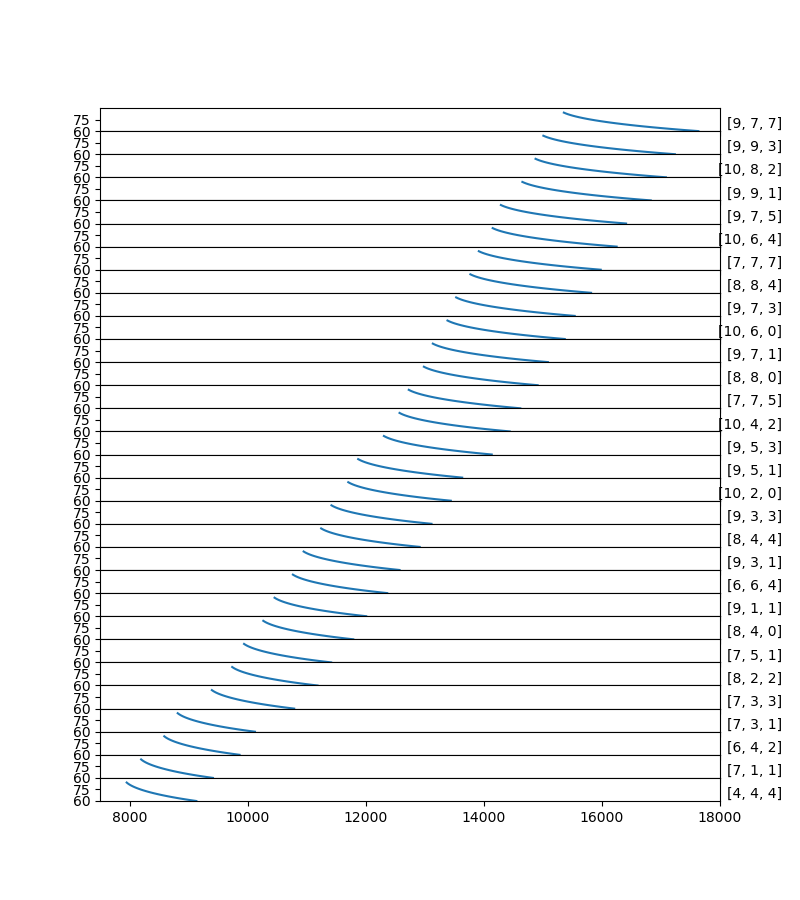

In [293]:
hkl_df = hkl_dataframe(hkl_list = hkl_list, figure=True, pltEmin=7500, pltEmax=18000)

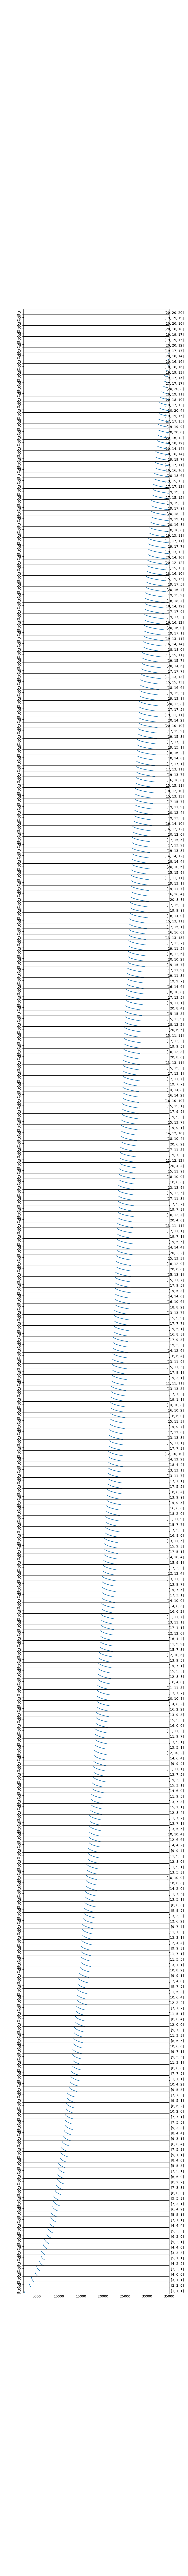

In [294]:
hkl_df_1=hkl_dataframe(hkl_list = ordered_hkl_list, figure=True, pltEmin=2000, pltEmax=35000)

# 2. Roland Circle for 1 SBCA

## HERFD Roland circle:

Dataframe of 10 < alpha < 20 and theta_B < 80:
         hkl  hkl_sq    theta_B      alpha    theta_M  angle_diff_1  \
1  [5, 5, 3]      59  71.383104  16.924497  88.307601     18.616896   
2  [7, 3, 1]      59  71.383104  16.924497  88.307601     18.616896   

   angle_diff_2  
1      1.924497  
2      1.924497  
hkl=[5, 5, 3], phi=39.23
theta_B=71.38, alpha=16.92, theta_M=88.31, Z=17.04, X=491.04
hkl=[7, 3, 1], phi=140.77
theta_B=71.38, alpha=16.92, theta_M=88.31, Z=17.04, X=491.04


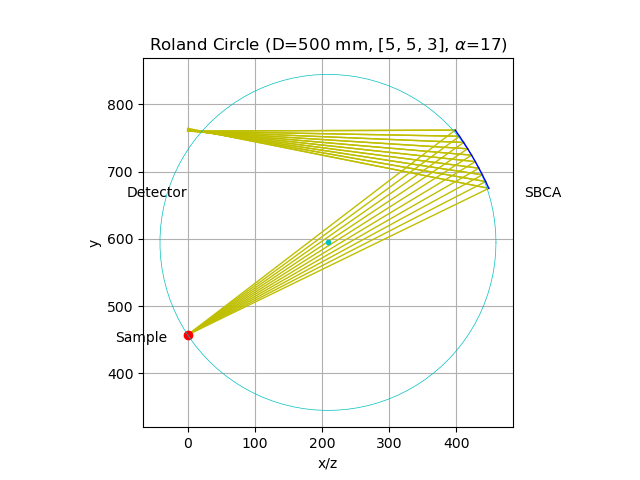

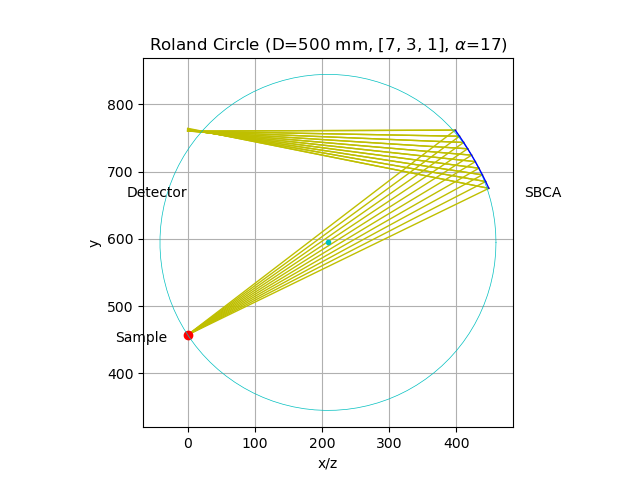

In [401]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
#herfd_roland_circle(E_emission=9866.42, angle2beam=90, view=[120,240,-30], reflected=True, focus=True, angle_list=True, threeD=False)
#herfd_roland_circle(E_emission=7480, beta=30, angle2beam=90, view=[120,240,-30], reflected=True, focus=True, angle_list=True, threeD=False)
herfd_roland_circle(E_emission=9251.74, beta=30, angle2beam=90, view=[120,240,-30], reflected=True, focus=True, angle_list=True, threeD=False)
herfd_roland_circle(hkl=[7,3,1], E_emission=9251.74, beta=30, angle2beam=90, view=[120,240,-30], reflected=True, focus=True, angle_list=True, threeD=False)

Dataframe of theta_B > 80
         hkl  hkl_sq    theta_B      alpha     theta_M  angle_diff_1  \
0  [6, 6, 0]      72  78.429545  30.000000  108.429545     11.570455   
1  [8, 2, 2]      72  78.429545  15.793169   94.222714     11.570455   

   angle_diff_2  
0     15.000000  
1      0.793169  
Dataframe of theta_B > 80 and smallest hkl_sq
         hkl  hkl_sq    theta_B      alpha     theta_M  angle_diff_1  \
0  [6, 6, 0]      72  78.429545  30.000000  108.429545     11.570455   
1  [8, 2, 2]      72  78.429545  15.793169   94.222714     11.570455   

   angle_diff_2  
0     15.000000  
1      0.793169  
hkl=[6, 6, 0], phi=90.00
theta_B=78.43, alpha=30.00, theta_M=108.43, Z=-299.92, X=709.77
Dataframe of theta_B > 80
          hkl  hkl_sq    theta_B      alpha     theta_M  angle_diff_1  \
0   [8, 6, 2]     104  78.788742  16.102114   94.890856     11.211258   
1  [10, 2, 0]     104  78.788742  28.272494  107.061236     11.211258   

   angle_diff_2  
0      1.102114  
1     13.272494

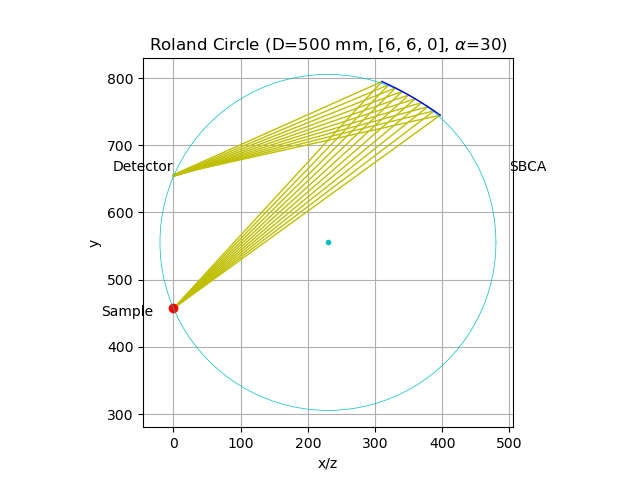

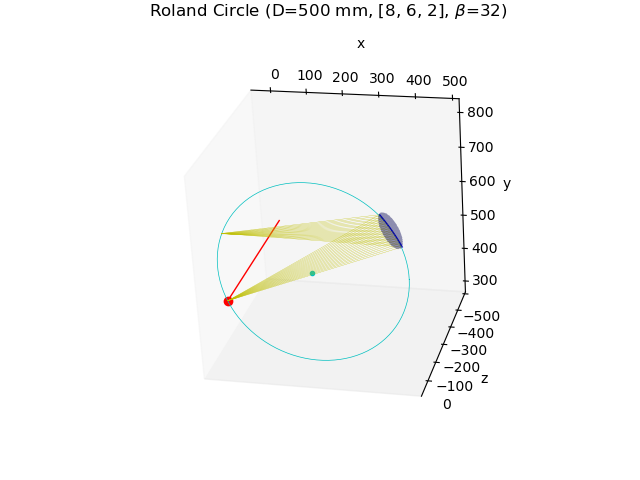

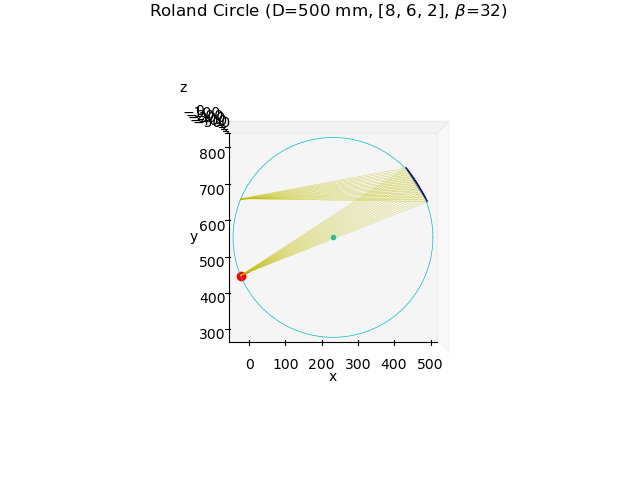

In [296]:
herfd_roland_circle(E_emission=9886.42, angle2beam=90, view=[120,240,-30], reflected=False, focus=False, angle_list=True, threeD=False)
herfd_roland_circle(E_emission=11867, angle2beam=90, view=[120,240,-30], reflected=True, focus=False, angle_list=False, threeD=True)
herfd_roland_circle(E_emission=11867, angle2beam=90, view=[90,270,0], reflected=True, focus=False, angle_list=False, threeD=True)

Dataframe of theta_B > 80
         hkl  hkl_sq    theta_B      alpha    theta_M  angle_diff_1  \
0  [5, 5, 3]      59  76.952138  16.924497  93.876635     13.047862   
1  [7, 3, 1]      59  76.952138  16.924497  93.876635     13.047862   

   angle_diff_2  
0      1.924497  
1      1.924497  
Dataframe of theta_B > 80 and smallest hkl_sq
         hkl  hkl_sq    theta_B      alpha    theta_M  angle_diff_1  \
0  [5, 5, 3]      59  76.952138  16.924497  93.876635     13.047862   
1  [7, 3, 1]      59  76.952138  16.924497  93.876635     13.047862   

   angle_diff_2  
0      1.924497  
1      1.924497  
hkl=[5, 5, 3], phi=39.23
theta_B=76.95, alpha=16.92, theta_M=93.88, Z=-38.94, X=517.19
Angle between Sample-SBCA and X-ray: 60
theta_B=76.95, alpha=16.92, theta_M=93.88, Z=-38.94, X=517.19
Angle between Sample-SBCA and X-ray: 80
theta_B=76.95, alpha=16.92, theta_M=93.88, Z=-38.94, X=517.19
Angle between Sample-SBCA and X-ray: 100
theta_B=76.95, alpha=16.92, theta_M=93.88, Z=-38.94, X=517.1

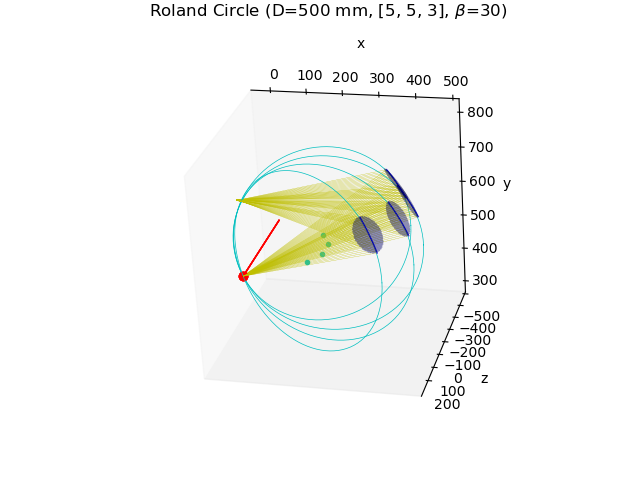

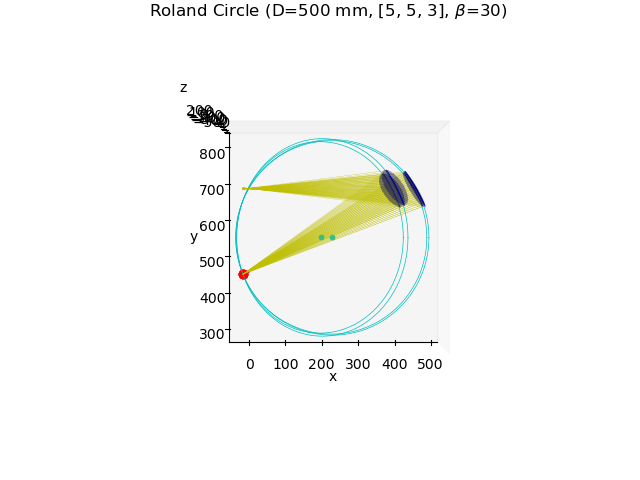

In [297]:
herfd_roland_circles(hkl=None, E_emission=9000, beta=30, view=[120,240,-30], reflected=True, focus=False, angle_list=True)
herfd_roland_circles(hkl=None, E_emission=9000, beta=30, view=[90,270,0], reflected=True, focus=False, angle_list=False)

Dataframe of 10 < alpha < 20 and theta_B > 80:
           hkl  hkl_sq    theta_B      alpha    theta_M  angle_diff_1  \
3  [10, 10, 4]     216  80.684556  19.188136  99.872693      9.315444   
5   [14, 4, 2]     216  80.684556  19.188136  99.872693      9.315444   

   angle_diff_2  
3      4.188136  
5      4.188136  


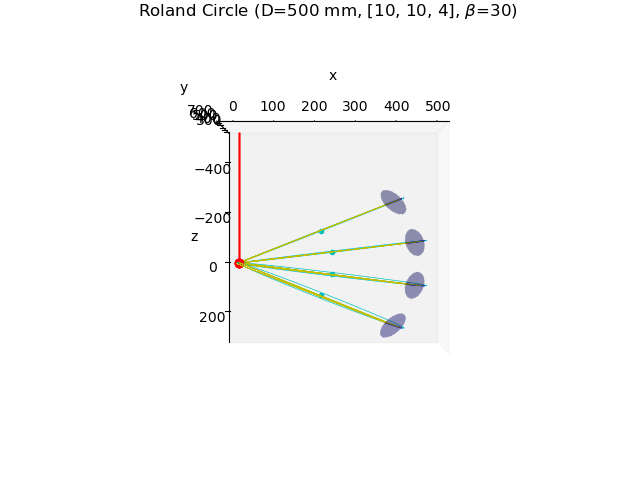

In [298]:
herfd_roland_circles(hkl=None, E_emission=17000, beta=30, view=[90+90,270,0], reflected=True, focus=False, angle_list=False)

## RIXS Roland circle moving

Dataframe of 10 < alpha < 20 and theta_B > 80:
         hkl  hkl_sq    theta_B      alpha    theta_M  angle_diff_1  \
0  [5, 5, 3]      59  80.106117  16.924497  97.030614      9.893883   
1  [7, 3, 1]      59  80.106117  16.924497  97.030614      9.893883   

   angle_diff_2  
0      1.924497  
1      1.924497  
hkl=[5, 5, 3], phi=39.23
theta_B=80.11, alpha=16.92, theta_M=97.03, Z=-70.14, X=527.58
theta_B=79.92, alpha=16.92, theta_M=96.85, Z=-68.35, X=527.07
theta_B=79.74, alpha=16.92, theta_M=96.67, Z=-66.59, X=526.55
theta_B=79.57, alpha=16.92, theta_M=96.49, Z=-64.86, X=526.04
theta_B=79.39, alpha=16.92, theta_M=96.32, Z=-63.16, X=525.52
theta_B=79.22, alpha=16.92, theta_M=96.15, Z=-61.49, X=525.01
theta_B=79.06, alpha=16.92, theta_M=95.98, Z=-59.84, X=524.49
theta_B=78.89, alpha=16.92, theta_M=95.82, Z=-58.22, X=523.97
theta_B=78.73, alpha=16.92, theta_M=95.66, Z=-56.62, X=523.45
theta_B=78.57, alpha=16.92, theta_M=95.50, Z=-55.04, X=522.93
theta_B=78.41, alpha=16.92, theta_M=95.3

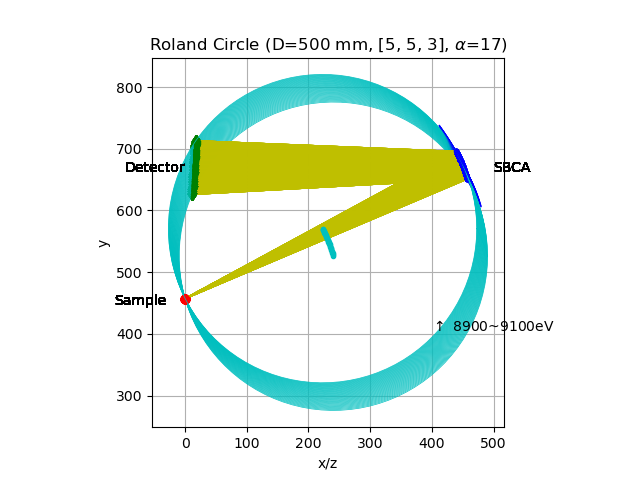

In [299]:
rixs_roland_circles(hkl=None, E_emission=9000, beta=30, delEn=-100, delEp=100, E_step=5, reflected=False, focus=False, angle_list=True)

# 3. Alpha-Phi plot 

/var/folders/qx/2kkbg9bn2y34j7b2h3w7vp9czm__9d/T/ipykernel_4294/3444436126.py:16: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


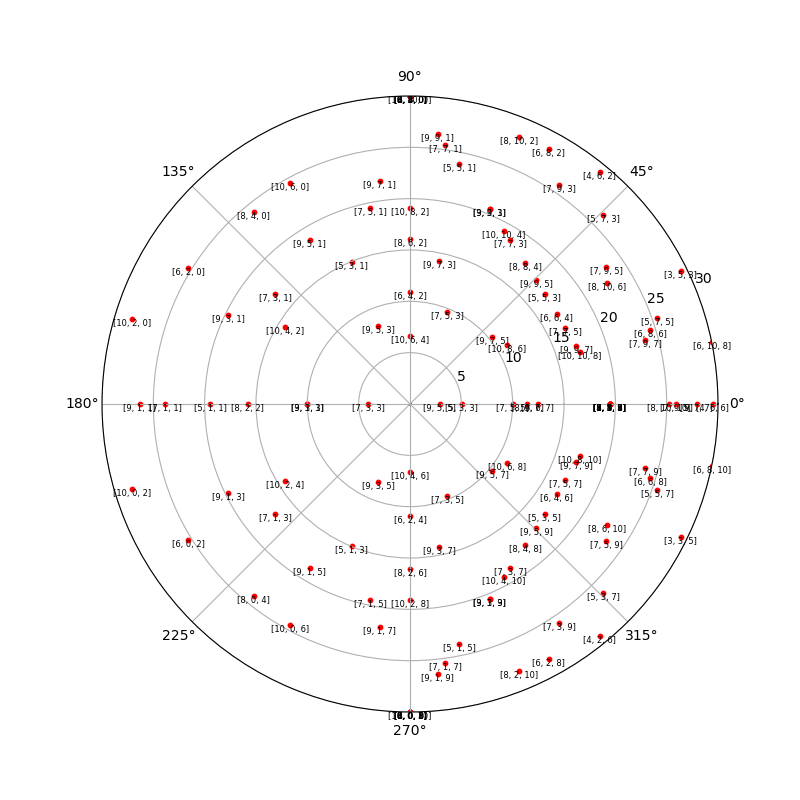

In [300]:
alpha_phi_scan = AlphaPhiScan()
fig, ax = alpha_phi_scan.visualize_alphi(num_points=0, pt_density=0.1, alpha_max=30)
plt.show()

# *Tests

In [301]:
hkls=[[6,4,2],[-6,4,2],[6,-4,2],[6,4,-2],[-6,-4,2],[-6,4,-2],[6,-4,-2],[-6,-4,-2]]
for hkl in hkls:
    phi_val = cal_phi(hkl_phi0,hkl)
    alpha_val = cal_alpha(hkl0, hkl) 
    print(f'{hkl}, phi={phi_val:.2f}, alpha={alpha_val:.2f}')

[6, 4, 2], phi=90.00, alpha=10.89
[-6, 4, 2], phi=11.54, alpha=109.11
[6, -4, 2], phi=222.57, alpha=56.94
[6, 4, -2], phi=118.56, alpha=40.20
[-6, -4, 2], phi=298.56, alpha=139.80
[-6, 4, -2], phi=42.57, alpha=123.06
[6, -4, -2], phi=191.54, alpha=70.89
[-6, -4, -2], phi=270.00, alpha=169.11


In [302]:
hkl_list1 = [[4,4,4],
             [3,3,1],
            [6,4,2],
            [4,4,0],
            [7,1,5],
            [5,3,5],
            [5,3,1],
            [6,2,0],
            [5,1,1],
            [9,3,3],
            [6,0,2],
            ]